In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import requests
from bs4 import BeautifulSoup

In [2]:
# Step 1: Data Collection
# Get all tickers from SPY using Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = [row.find_all('td')[0].text.strip() for row in table.find_all('tr')[1:]]

In [3]:
# Download historical data for these tickers
data = yf.download(tickers, start='2016-01-01', end='2023-01-01', group_by='ticker')

[**********************83%%**************        ]  419 of 503 completed

$BF.B: possibly delisted; No price data found  (1d 2016-01-01 -> 2023-01-01)


[*********************100%%**********************]  503 of 503 completed

6 Failed downloads:
['GEV', 'KVUE', 'SOLV', 'VLTO']: YFChartError("%ticker%: Data doesn't exist for startDate = 1451624400, endDate = 1672549200")
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2016-01-01 -> 2023-01-01)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


In [4]:
# Download fundamental data
fundamentals = {}
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        # Retrieve financial data
        financials = stock.financials.T
        cashflow = stock.cashflow.T
        
        # Calculate additional fundamental metrics
        revenue_growth = (financials['Total Revenue'].pct_change(periods=4).iloc[-1] if 'Total Revenue' in financials else np.nan)
        net_income_growth = (financials['Net Income'].pct_change(periods=4).iloc[-1] if 'Net Income' in financials else np.nan)
        ev_ebit = info.get('enterpriseToEbitda', np.nan)
        fcf_growth = (cashflow['Free Cash Flow'].pct_change(periods=4).iloc[-1] if 'Free Cash Flow' in cashflow else np.nan)
        eps = info.get('trailingEps', np.nan)
        
        fundamentals[ticker] = {
            'P/E': info.get('forwardPE', np.nan),
            'P/B': info.get('priceToBook', np.nan),
            'ROE': info.get('returnOnEquity', np.nan),
            'Dividend Yield': info.get('dividendYield', np.nan),
            'Revenue Growth Rate': revenue_growth,
            'Net Income Growth Rate': net_income_growth,
            'EV/EBIT': ev_ebit,
            'FCF Growth Rate': fcf_growth,
            'EPS': eps
        }
    except Exception as e:
        print(f"Could not download fundamentals for {ticker}: {e}")

In [5]:
fundamentals

{'MMM': {'P/E': 12.91923,
  'P/B': 11.458949,
  'ROE': -0.69286,
  'Dividend Yield': 0.0278,
  'Revenue Growth Rate': -0.015207612986138708,
  'Net Income Growth Rate': -1.7789849892780558,
  'EV/EBIT': 8.239,
  'FCF Growth Rate': 0.3054294175715695,
  'EPS': -12.73},
 'AOS': {'P/E': 19.36092,
  'P/B': 6.5643024,
  'ROE': 0.31443,
  'Dividend Yield': 0.0152,
  'Revenue Growth Rate': nan,
  'Net Income Growth Rate': nan,
  'EV/EBIT': 14.781,
  'FCF Growth Rate': -0.15459260498577887,
  'EPS': 3.85},
 'ABT': {'P/E': 20.231518,
  'P/B': 4.6613474,
  'ROE': 0.14762,
  'Dividend Yield': 0.0212,
  'Revenue Growth Rate': -0.13715126280884593,
  'Net Income Growth Rate': -0.2145727765158134,
  'EV/EBIT': 18.248,
  'FCF Growth Rate': 0.13144890294524614,
  'EPS': 3.21},
 'ABBV': {'P/E': 14.208955,
  'P/B': 37.78611,
  'ROE': 0.56244,
  'Dividend Yield': 0.036199998,
  'Revenue Growth Rate': -0.1567436208991495,
  'Net Income Growth Rate': -0.05079169237096448,
  'EV/EBIT': 13.744,
  'FCF Growth

In [6]:
fundamentals_df = pd.DataFrame(fundamentals).T

In [7]:
fundamentals_df

,P/E,P/B,ROE,Dividend Yield,Revenue Growth Rate,Net Income Growth Rate,EV/EBIT,FCF Growth Rate,EPS
MMM,12.919230,11.458949,-0.69286,0.0278,-0.015208,-1.778985,8.239,0.305429,-12.73
AOS,19.360920,6.564302,0.31443,0.0152,NaN,NaN,14.781,-0.154593,3.85
ABT,20.231518,4.661347,0.14762,0.0212,-0.137151,-0.214573,18.248,0.131449,3.21
ABBV,14.208955,37.786110,0.56244,0.0362,-0.156744,-0.050792,13.744,-0.238963,3.36
ACN,22.000770,6.615738,0.27381,0.0181,NaN,NaN,15.808,-0.153408,11.04
...,...,...,...,...,...,...,...,...,...
XYL,29.489492,3.338883,0.09614,0.0103,-0.337860,-0.582923,24.613,0.132509,2.88
YUM,21.259027,NaN,NaN,0.0198,-0.201244,-0.433939,19.220,-0.131259,5.63
ZBRA,20.071380,4.788822,0.08614,NaN,-0.029668,0.702703,24.936,-10.835165,5.05
ZBH,12.277331,1.742020,0.07795,0.0090,-0.171310,-1.135645,11.146,-0.092600,4.61


In [8]:
# Step 2: Data Preprocessing
# Fill missing values with mean of the column
fundamentals_df = fundamentals_df.fillna(fundamentals_df.mean())


In [9]:
# Normalize the data
scaler = StandardScaler()
fundamentals_normalized = pd.DataFrame(scaler.fit_transform(fundamentals_df), index=fundamentals_df.index, columns=fundamentals_df.columns)

In [10]:
fundamentals_normalized

,P/E,P/B,ROE,Dividend Yield,Revenue Growth Rate,Net Income Growth Rate,EV/EBIT,FCF Growth Rate,EPS
MMM,-0.456230,1.491269e-03,-0.179963,0.268122,1.401398,-3.455564e-01,-0.747682,0.079622,-0.872688
AOS,-0.026658,-7.253193e-02,-0.057182,-0.640506,0.000000,4.332292e-17,-0.270941,0.001365,-0.180236
ABT,0.031399,-1.013109e-01,-0.077515,-0.207826,0.705410,2.649057e-01,-0.018287,0.050025,-0.206965
ABBV,-0.370223,3.996448e-01,-0.026952,0.873874,0.593587,3.288161e-01,-0.346511,-0.012987,-0.200701
ACN,0.149383,-7.175406e-02,-0.062133,-0.431377,0.000000,4.332292e-17,-0.196099,0.001567,0.120049
...,...,...,...,...,...,...,...,...,...
XYL,0.648778,-1.213109e-01,-0.083790,-0.993861,-0.440125,1.211688e-01,0.445556,0.050205,-0.220748
YUM,0.099919,2.686438e-17,0.000000,-0.308784,0.339606,1.793052e-01,0.052547,0.005335,-0.105896
ZBRA,0.020720,-9.938306e-02,-0.085009,0.000000,1.318864,6.228433e-01,0.469094,-1.815550,-0.130119
ZBH,-0.499036,-1.454608e-01,-0.086007,-1.087609,0.510451,-9.451323e-02,-0.535837,0.011911,-0.148495


In [11]:
# Step 3: Factor Scoring and Ranking
def calculate_scores(df):
    scores = df.sum(axis=1)
    return scores.sort_values(ascending=False)

In [30]:
# Calculate scores and rank stocks each quarter
quarters = pd.date_range(start='2016-01-01', end='2023-01-01', freq='Q')
quarterly_returns = []
traded_stocks_per_quarter = []

In [31]:
for i in range(1, len(quarters)):
    quarter_start = quarters[i-1]
    quarter_end = quarters[i]
    
    # Calculate scores for the quarter
    scores = calculate_scores(fundamentals_normalized)
    ranked_stocks = scores.sort_values(ascending=False)
    
    # Select top N stocks
    top_n = 10
    selected_stocks = ranked_stocks.head(top_n).index.tolist()
    traded_stocks_per_quarter.append(selected_stocks)
    
    # Calculate returns for the selected stocks
    try:
        # Accessing the 'Adj Close' prices for selected stocks
        quarter_data = data.loc[quarter_start:quarter_end, (slice(None), 'Adj Close')][selected_stocks]
        if quarter_data.empty:
            print(f"No data available for selected stocks in the quarter ending {quarter_end}")
            quarterly_returns.append(0)
            continue
        
        # Dropping columns with missing data
        quarter_data = quarter_data.dropna(axis=1, how='all')
        
        if not quarter_data.empty:
            returns = (quarter_data.iloc[-1] - quarter_data.iloc[0]) / quarter_data.iloc[0]
            quarterly_returns.append(returns.mean())
        else:
            print(f"All selected stocks have missing data for the quarter ending {quarter_end}")
            quarterly_returns.append(0)
    except Exception as e:
        print(f"Error calculating returns for the quarter ending {quarter_end}: {e}")
        quarterly_returns.append(0)

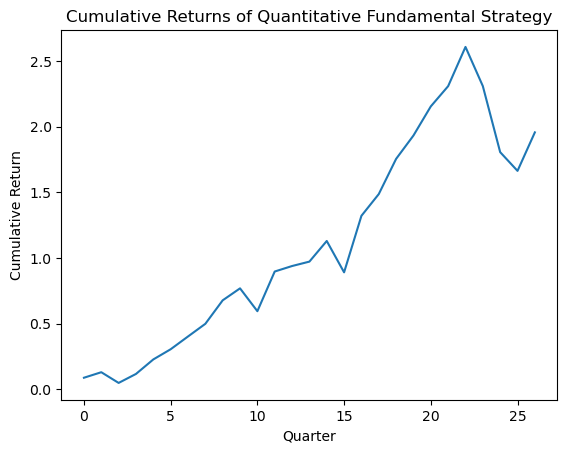

In [32]:
cumulative_returns = (1 + pd.Series(quarterly_returns)).cumprod() - 1
cumulative_returns.plot(title='Cumulative Returns of Quantitative Fundamental Strategy')
plt.xlabel('Quarter')
plt.ylabel('Cumulative Return')
plt.show()

In [33]:
for i, stocks in enumerate(traded_stocks_per_quarter):
    print(f"Quarter {i+1} ({quarters[i+1].date()}): {len(stocks)} stocks traded")
    print(stocks)

Quarter 1 (2016-06-30): 10 stocks traded
['IRM', 'AON', 'NVR', 'RVTY', 'PANW', 'CSGP', 'DLR', 'INTC', 'CLX', 'AXON']
Quarter 2 (2016-09-30): 10 stocks traded
['IRM', 'AON', 'NVR', 'RVTY', 'PANW', 'CSGP', 'DLR', 'INTC', 'CLX', 'AXON']
Quarter 3 (2016-12-31): 10 stocks traded
['IRM', 'AON', 'NVR', 'RVTY', 'PANW', 'CSGP', 'DLR', 'INTC', 'CLX', 'AXON']
Quarter 4 (2017-03-31): 10 stocks traded
['IRM', 'AON', 'NVR', 'RVTY', 'PANW', 'CSGP', 'DLR', 'INTC', 'CLX', 'AXON']
Quarter 5 (2017-06-30): 10 stocks traded
['IRM', 'AON', 'NVR', 'RVTY', 'PANW', 'CSGP', 'DLR', 'INTC', 'CLX', 'AXON']
Quarter 6 (2017-09-30): 10 stocks traded
['IRM', 'AON', 'NVR', 'RVTY', 'PANW', 'CSGP', 'DLR', 'INTC', 'CLX', 'AXON']
Quarter 7 (2017-12-31): 10 stocks traded
['IRM', 'AON', 'NVR', 'RVTY', 'PANW', 'CSGP', 'DLR', 'INTC', 'CLX', 'AXON']
Quarter 8 (2018-03-31): 10 stocks traded
['IRM', 'AON', 'NVR', 'RVTY', 'PANW', 'CSGP', 'DLR', 'INTC', 'CLX', 'AXON']
Quarter 9 (2018-06-30): 10 stocks traded
['IRM', 'AON', 'NVR', '